In [130]:
import math
import matplotlib.pyplot as plt
import numpy as np

from collections import deque

In [131]:
def bresenham(start, end):
    """
    Implementation of Bresenham's line drawing algorithm
    See en.wikipedia.org/wiki/Bresenham's_line_algorithm
    Bresenham's Line Algorithm
    Produces a np.array from start and end (original from roguebasin.com)
    >>> points1 = bresenham((4, 4), (6, 10))
    >>> print(points1)
    np.array([[4,4], [4,5], [5,6], [5,7], [5,8], [6,9], [6,10]])
    """
    # setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)  # determine how steep the line is
    if is_steep:  # rotate line
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    # swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1  # recalculate differentials
    dy = y2 - y1  # recalculate differentials
    error = int(dx / 2.0)  # calculate error
    y_step = 1 if y1 < y2 else -1
    # iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = [y, x] if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += y_step
            error += dx
    if swapped:  # reverse the list if the coordinates were swapped
        points.reverse()
    points = np.array(points)
    return points

In [132]:
f = "sampling_10.csv"

with open(f) as data:
    measures = [line.split(",") for line in data]
angles = []
distances = []
for measure in measures:
    angles.append(float(measure[0]))
    distances.append(float(measure[2]))
angles = np.array(angles)
distances = np.array(distances)


In [133]:
ang = angles
dist = distances

ox = np.sin(ang*3.14/180) * dist
oy = np.cos(ang*3.14/180) * dist

In [142]:
"""
Calculates the size, and the maximum distances according to the the
measurement center
"""
EXTEND_AREA = 2.0
xy_resolution = 1

min_x = round(min(ox) - EXTEND_AREA / 2.0)
min_y = round(min(oy) - EXTEND_AREA / 2.0)
max_x = round(max(ox) + EXTEND_AREA / 2.0)
max_y = round(max(oy) + EXTEND_AREA / 2.0)
xw = int(round((max_x - min_x) / xy_resolution))
yw = int(round((max_y - min_y) / xy_resolution))
#print("The grid map is ", xw, "x", yw, ".")

In [135]:
min_x = min_x
min_y = min_y
max_x = max_x
max_y = max_y
x_w = xw
y_w = yw

occupancy_map = np.zeros((x_w, y_w)) / 2
center_x = int(round(-min_x / xy_resolution))  # center x coordinate of the grid map
center_y = int(round(-min_y / xy_resolution))  # center y coordinate of the grid map

In [136]:
center_x, center_y = (center_x, center_y)
prev_ix, prev_iy = center_x - 1, center_y
ox, oy = (ox, oy)
xw, yw = (x_w, y_w)
min_x, min_y = (min_x, min_y)

occupancy_map = (np.ones((xw, yw))) #* 0.5
for (x, y) in zip(ox, oy):
    # x coordinate of the the occupied area
    ix = int(round((x - min_x) / xy_resolution))
    # y coordinate of the the occupied area
    iy = int(round((y - min_y) / xy_resolution))
    free_area = bresenham((prev_ix, prev_iy), (ix, iy))
    for fa in free_area:
        occupancy_map[fa[0]][fa[1]] = 0  # free area 0.0
    prev_ix = ix
    prev_iy = iy
# return occupancy_map

In [137]:
"""
center_point: starting point (x,y) of fill
occupancy_map: occupancy map generated from Bresenham ray-tracing
"""
center_point = (center_x, center_y)

# Fill empty areas with queue method
sx, sy = occupancy_map.shape
fringe = deque()
fringe.appendleft(center_point)
while fringe:
    n = fringe.pop()
    nx, ny = n
    # West
    if nx > 0:
        if occupancy_map[nx - 1, ny] == 0.5:
            occupancy_map[nx - 1, ny] = 0.0
            fringe.appendleft((nx - 1, ny))
    # East
    if nx < sx - 1:
        if occupancy_map[nx + 1, ny] == 0.5:
            occupancy_map[nx + 1, ny] = 0.0
            fringe.appendleft((nx + 1, ny))
    # North
    if ny > 0:
        if occupancy_map[nx, ny - 1] == 0.5:
            occupancy_map[nx, ny - 1] = 0.0
            fringe.appendleft((nx, ny - 1))
    # South
    if ny < sy - 1:
        if occupancy_map[nx, ny + 1] == 0.5:
            occupancy_map[nx, ny + 1] = 0.0
            fringe.appendleft((nx, ny + 1))

In [138]:
for (x, y) in zip(ox, oy):
    # x coordinate of the the occupied area
    ix = int(round((x - min_x) / xy_resolution)) -1
    # y coordinate of the the occupied area
    iy = int(round((y - min_y) / xy_resolution)) -1
    laser_beams = bresenham((center_x, center_y), (ix, iy))  # line form the lidar to the occupied point
    for laser_beam in laser_beams:
        occupancy_map[laser_beam[0]][
            laser_beam[1]] = 0.0  # free area 0.0
    occupancy_map[ix][iy] = 1.0  # occupied area 1.0
    occupancy_map[ix + 1][iy] = 1.0  # extend the occupied area
    occupancy_map[ix][iy + 1] = 1.0  # extend the occupied area
    occupancy_map[ix + 1][iy + 1] = 1.0  # extend the occupied area

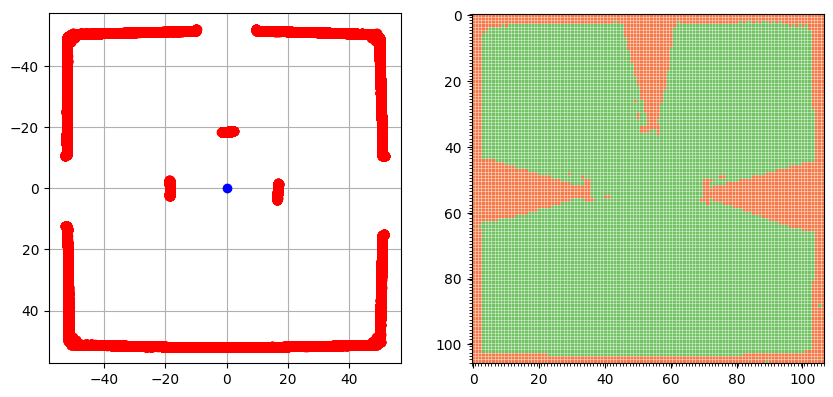

In [139]:
xy_res = np.array(occupancy_map).shape
plt.figure(1, figsize=(10, 10))
plt.subplot(122)
plt.imshow(occupancy_map, cmap="RdYlGn_r")
# cmap = "binary" "PiYG_r" "PiYG_r" "bone" "bone_r" "RdYlGn_r"
plt.clim(-0.4, 1.4)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="minor", color="w", linewidth=0.6, alpha=0.5)
# plt.colorbar()
plt.subplot(121)
plt.plot([oy], [ox], "ro-") 
# plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-")
plt.axis("equal")
plt.plot(0.0, 0.0, "ob")
plt.gca().set_aspect("equal", "box")
bottom, top = plt.ylim()  # return the current y-lim
plt.ylim((top, bottom))  # rescale y axis, to match the grid orientation
plt.grid(True)
plt.show()